### MWE Cross-isobath transport

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format='retina'

In [2]:
from matplotlib import rc
rc('font', **{'size':20})
rc('text', usetex=False)
rc('xtick', labelsize=26) #20 
rc('ytick', labelsize=26) #20
rc('axes', titlesize=26)    # fontsize of the axes title
rc('axes', labelsize=26) #24    # fontsize of the x and y labels

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xarray as xr
from xgcm import Grid
import xgcm

In [3]:
## animation block preamble
from matplotlib.animation import FuncAnimation
import IPython
from IPython.display import HTML, display, clear_output

In [4]:
from dask.distributed import Client

c=Client(local_directory = '/scratch/v45/qo9901/') 
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37891,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:40675,Total threads: 2
Dashboard: /proxy/43799/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:41839,


In [5]:
from matplotlib import ticker, cm

In [80]:
### Make simplified topography grid
topo_var = np.flip(np.asarray([[-1.1,-1.1,-1.1,-1.1,-1.1],[-1.1,-1.1,-1.1,-1.1,-1.1],[-.5,-.5,-1.1,-.5,-.5],[-.5,-.5,-1.1,-.5,-.5],[-.5,-.5,-.5,-.5,-.5],[-.5,-.5,-.5,-.5,-.5]]) *1000, axis = 0)
xh = np.arange(-2,3,1)
yh = np.arange(-3,3,1)

ds_topo =  xr.Dataset(data_vars = dict( topo =( ['yh','xh'],topo_var)), coords = dict(xh = (['xh'], xh),yh = (['yh'],yh)))
topo = ds_topo.topo

In [92]:
topo_var

array([[ -500.,  -500.,  -500.,  -500.,  -500.],
       [ -500.,  -500.,  -500.,  -500.,  -500.],
       [ -500.,  -500., -1100.,  -500.,  -500.],
       [ -500.,  -500., -1100.,  -500.,  -500.],
       [-1100., -1100., -1100., -1100., -1100.],
       [-1100., -1100., -1100., -1100., -1100.]])

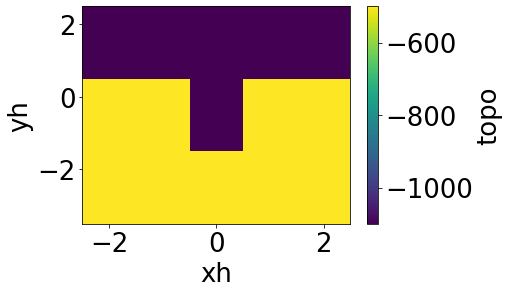

In [81]:
ds_topo.topo.plot()

In [199]:
## make velocity fields - the ireegular field was to help with spotting mistakes
xq = xh + 0.5
yq = yh + 0.5
v = np.flip(np.asarray([[0.33,0.33,0.33,0.33,0.33],[0.33,0.33,0.33,0.33,0.33],[-10,-10,0.33,-10,-10],[0.33,0.33,0.33,0.33,0.33],[0.33,0.33,-10,0.33,0.33],[0.33,0.33,0.33,0.33,0.33]]), axis = 0)
u = np.flip(np.asarray([[0.13,0.13,0.13,0.13,0.13],[0.13,0.13,0.13,0.13,0.13],[0.13,-10,0.13,-10,0.13],[0.13,-10,0.13,-10,0.13],[0.13,0.13,0.13,0.13,0.13],[0.13,0.13,0.13,0.13,0.13]]), axis = 0)

ds_velocities =  xr.Dataset(data_vars = dict( u =( ['yh','xq'],u), v =( ['yq','xh'],v)), coords = dict(xh = (['xh'], xh),yh = (['yh'],yh),xq = (['xq'], xq),yq = (['yq'],yq)))

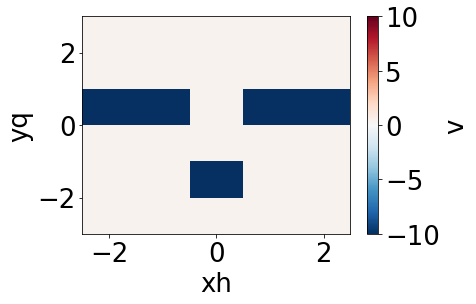

In [200]:
#Poleward flow and westward jet represented
ds_velocities.v.plot()

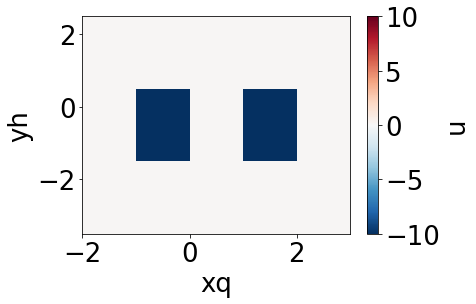

In [201]:
ds_velocities.u.plot()

In [222]:
ds.coords['xh']

<xarray.DataArray 'xh' (xh: 5)>
array([-2, -1,  0,  1,  2])
Coordinates:
  * xh       (xh) int64 -2 -1 0 1 2
Attributes:
    axis:     X

In [223]:
ds.coords['xq']

<xarray.DataArray 'xq' (xq: 5)>
array([-1.5, -0.5,  0.5,  1.5,  2.5])
Coordinates:
  * xq       (xq) float64 -1.5 -0.5 0.5 1.5 2.5
Attributes:
    axis:               X
    c_grid_axis_shift:  0.5

In [202]:
ds = xr.merge([ds_velocities.u, ds_velocities.v])
ds.coords['xh'].attrs.update(axis='X')
ds.coords['xq'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yh'].attrs.update(axis='Y')
ds.coords['yq'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [203]:
topo_deep = xr.where(topo < -1000, topo,np.nan)
topo_shallow = xr.where(topo > -1000, topo,np.nan) 
topo_deep

<xarray.DataArray 'topo' (yh: 6, xh: 5)>
array([[   nan,    nan,    nan,    nan,    nan],
       [   nan,    nan,    nan,    nan,    nan],
       [   nan,    nan, -1100.,    nan,    nan],
       [   nan,    nan, -1100.,    nan,    nan],
       [-1100., -1100., -1100., -1100., -1100.],
       [-1100., -1100., -1100., -1100., -1100.]])
Coordinates:
  * xh       (xh) int64 -2 -1 0 1 2
  * yh       (yh) int64 -3 -2 -1 0 1 2

In [219]:
### Constructing the mask - the key problem

v_cross_mask = (ds_velocities.v *np.nan ).values
u_cross_mask = (ds_velocities.u *np.nan ).values

for i in range(len(ds_topo.coords['xh'])-1):
    for j in range(len(ds_topo.coords['yh'])-1):
    
        #print(i,j)
        
        if np.isfinite(topo_deep.isel(xh = i, yh = j)) :
            if np.isnan(topo_deep.isel(xh = i, yh = j+1)):
            #label as the boundary for cross-slope transport
                v_cross_mask[j,i]= 1
                #print('TRUE **shd not be here')

            if np.isnan(topo_deep.isel(xh = i, yh = j-1)):
                v_cross_mask[j-1,i] = -1
                #print('TRUE')
                 

            if np.isnan(topo_deep.isel(xh = i-1, yh = j)):
                u_cross_mask[j,i-1] = - 1
                #print('TRUEu ')

            if np.isnan(topo_deep.isel(xh = i+1, yh = j)):
                u_cross_mask[j,i+1] = 1
                #print('TRUEu+')
                
i = len(ds_topo.coords['xh'])-1
for j in range(len(ds_topo.coords['yh'])-1):

    #print(i,j)

    if np.isfinite(topo_deep.isel(xh = i, yh = j)) :
        if np.isnan(topo_deep.isel(xh = i, yh = j+1)):
        #label as the boundary for cross-slope transport
            v_cross_mask[j,i]= 1
           # print('TRUE **shd not be here')

        if np.isnan(topo_deep.isel(xh = i, yh = j-1)):
            v_cross_mask[j-1,i] = -1
            #print('TRUE')


        if np.isnan(topo_deep.isel(xh = i-1, yh = j)):
            u_cross_mask[j,i-1] =  -1
            #print('TRUEu ')

        if np.isnan(topo_deep.isel(xh = 0, yh = j)):
            u_cross_mask[j,i] = 1
            #print('TRUEu+')

In [205]:
u_cross_mask 

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, -1., nan,  1., nan],
       [nan, -1., nan,  1., nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [206]:
v_cross_mask 

array([[nan, nan, nan, nan, nan],
       [nan, nan, -1., nan, nan],
       [nan, nan, nan, nan, nan],
       [-1., -1., nan, -1., -1.],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [207]:
#Applying mask to velocities
u_transport = u_cross_mask * ds_velocities.u 
v_transport = v_cross_mask * ds_velocities.v

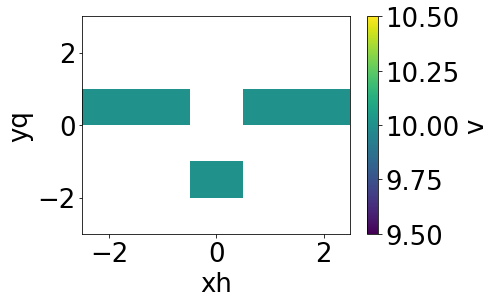

In [208]:
v_transport.plot()

In [209]:
topo_deep[0,0].values

array(nan)

### Plotting total poleward transport with distance in x(km)
Compressed matrices into single matrix with master coordinates xx

In [213]:
u_cross_interp = u_transport.rename({'xq':'xx','yh':'yy'})
v_cross_interp = v_transport.rename({'xh':'xx','yq':'yy'})

In [214]:
master_transport = v_cross_interp.combine_first(u_cross_interp)

In [215]:
master_transport_compressed = master_transport.sum(dim = 'yy')

In [216]:
master_transport_compressed 

<xarray.DataArray 'v' (xx: 10)>
array([ 10.,   0.,  10.,  20.,  10.,   0.,  10., -20.,  10.,   0.])
Coordinates:
  * xx       (xx) float64 -2.0 -1.5 -1.0 -0.5 0.0 0.5 1.0 1.5 2.0 2.5

### Cumulative cross-isobath transport at 1000m depth. 
Positive number indicates transport onto the cotinental shelf

** Currently unable to plot a plot with distance along contour, can't work out how to follow the contour directly?

Note that the cumulative transport is 50m3s-1 at the end of the channel, consistent with our calculations by hand. 

Text(0.5, 0, 'x(km)')

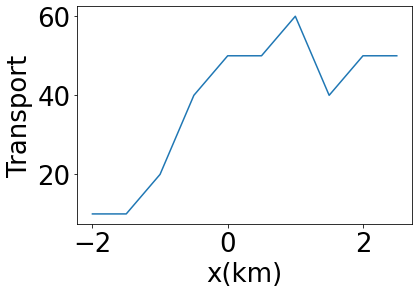

In [217]:
plt.figure()
master_transport_compressed.cumsum().plot()
plt.ylabel('Transport onto continental shelf')
plt.xlabel('x(km)')

# ignore below please 

In [210]:
contour_len = np.count_nonzero(~np.isnan(u_transport)) + np.count_nonzero(~np.isnan(v_transport))

In [211]:
contour_len

9

In [ ]:
contourline= []
contourlen = 0
i = 0 #len(ds_topo.coords['xh'])-1
j = 0
while i <len(ds_topo.coords['xh']):
   
    print(i,j)
    if np.isnan(topo_shallow[j,i]):
        if np.isfinite(v_transport.isel(xh = i,yq = j-1)):
            contourline = np.append(contourline, v_transport.isel(xh = i,yq = j-1))
            contourlen += 1
            print('finitev')
            if np.isnan(topo_shallow[j,i+1]):
                i += 1
                print('moved')
            else:
                j +=1
                

        if np.isfinite(u_transport.isel(xq = i,yh = j-1)):
            contourline = np.append(contourline, u_transport.isel(xq = i,yh = j))
            contourlen += 1
            j += 1
            print('utrans')
            
    else:
        j += 1
        print('else')

In [143]:
contourline

array([-10., -10.])

In [59]:
topo_deep_truth = ((topo_deep * 0) + 1).values

In [60]:
topo_shallow_truth = ((topo_shallow * 0) + 1).values

In [61]:
topo_deep_truth

array([[nan, nan, nan, nan, nan],
       [nan, nan,  1., nan, nan],
       [nan, nan,  1., nan, nan],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.]])

In [ ]:
v_cross_truth = - grid.interp(topo_deep_truth, axis = 'Y', boundary = "extend") * 


In [39]:
v_cross_truth_min = [ - topo_deep_truth[j+1,i] * topo_shallow_truth[j,i] for j in range(0,len(ds_topo.coords['yq'])-1) for i in range(len(ds_topo.coords['xh']))]
v_cross_truth_min = np.append(v_cross_truth_min, np.ones((len(ds_topo.coords['yq'])))*np.nan)
v_cross_truth_min = np.reshape(v_cross_truth_min,(len(ds_topo.coords['yq']),len(ds_topo.coords['xh'])))
v_cross_truth_max =  np.ones((len(ds_topo.coords['xh'])))*np.nan
v_cross_truth_max =  np.append(v_cross_truth_max,[topo_deep_truth[j-1,i] * topo_shallow_truth[j,i] for j in range(1,len(ds_topo.coords['yq']))for i in range(len(ds_topo.coords['xh']))])
v_cross_truth_max = np.reshape(v_cross_truth_max,(len(ds_topo.coords['yq']),len(ds_topo.coords['xh'])))
v_cross_truth =  np.nansum( np.dstack((v_cross_truth_max, v_cross_truth_min)),2)

In [40]:
v_cross_truth

array([[ 0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [-1., -1.,  0., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [53]:
u_cross_truth_min =  np.ones((len(ds_topo.coords['yh'])))*np.nan
u_cross_truth_min =np.append(u_cross_truth_min,[-topo_deep_truth[j,i] * topo_shallow_truth[j,i] for i in range (1,len(ds_topo.coords['xh'])) for j in range(0,len(ds_topo.coords['yh']))]) 
#u_cross_truth_min = np.append(u_cross_truth_min, np.ones((500))*np.nan)
u_cross_truth_min =np.transpose(np.reshape(u_cross_truth_min,(len(ds_topo.coords['xh']),len(ds_topo.coords['yh']))))


In [54]:
u_cross_truth_max =[topo_deep_truth[j,i] * topo_shallow_truth[j,i+1] for i in range (len(ds_topo.coords['xh'])-1) for j in range(0,len(ds_topo.coords['yh']))]
u_cross_truth_max = np.append(u_cross_truth_max, np.ones((len(ds_topo.coords['yh'])))*np.nan)
u_cross_truth_max = np.transpose(np.reshape(u_cross_truth_max,(len(ds_topo.coords['xh']),len(ds_topo.coords['yh']))))
u_cross_truth =  np.nansum( np.dstack((u_cross_truth_max, u_cross_truth_min)),2)

In [55]:
u_cross_truth_max

array([[nan, nan, nan, nan, nan],
       [nan, nan,  1., nan, nan],
       [nan, nan,  1., nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [62]:
ds_utruth =  xr.Dataset(data_vars = dict( utruth =( ['yh','xh'],u_cross_truth_max)), coords = dict(xh = (['xh'], xh),yh = (['yh'],yh)))
grid.interp(ds_utruth.utruth, axis = 'X')

<xarray.DataArray (yh: 5, xq: 5)>
array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])
Coordinates:
  * yh       (yh) int64 -2 -1 0 1 2
  * xq       (xq) float64 -1.5 -0.5 0.5 1.5 2.5

In [32]:
%%time

u_DSW = (dsx_prog_daily.u.isel(zl = nlayers - 2, Time = t)* grid.diff(h,'X')/10**3).mean('Time').values
v_DSW = (dsx_prog_daily.v.isel(zl = nlayers - 2, Time = t)* grid.diff(h,'Y', boundary = "extend")/10**3).mean('Time').values

#v_cross_matrix =  np.nansum( np.dstack(([(v_cross_truth_min * v_DSW)[j,i]*(h_crossv[j+1,i] - h_crossv[j,i])  for j in range(0,499)for i in range (1000)],[(v_cross_truth_max* v_DSW)[j,i]*(h_crossv[j,i] - h_crossv[j-1,i])  for j in range(1,500)for i in range (1000)] )),2)
v_cross_matrix =  np.nansum( np.dstack((v_cross_truth_min * v_DSW , v_cross_truth_max* v_DSW)),2)
u_cross_matrix =  np.nansum( np.dstack((u_cross_truth_min * u_DSW , u_cross_truth_max* u_DSW)),2)

CPU times: user 296 ms, sys: 14.6 ms, total: 311 ms
Wall time: 922 ms


In [ ]:
ds_cross_isobath_velocities = xr.Dataset(data_vars = dict( v_cross =( ['yq','xh'],v_cross_matrix), u_cross = (['yh','xq',],u_cross_matrix)), coords = dict(xh = (['xh'], ds.coords['xh'].data),yh = (['yh'], ds.coords['yh'].data), xq = (['xq'], ds.coords['xq'].data), yq = (['yq'], ds.coords['yq'].data)))